---

# Part III: Training Deep Q-Network to Solve Cartpole Problem from Open AI Gym.

---


In [1]:
!pip install gym==0.26

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import collections
import numpy as np
import random
import torch

# Replay buffer
class ReplayBuffer:
    
    # create replay buffer of size N
    def __init__(self, N):
        self.buf = collections.deque(maxlen = N)
    
    # add: add a transition (s, a, r, s2, d)
    def add(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    
    # sample: return minibatch of size n
    def sample(self, n, t):
        minibatch = random.sample(self.buf, n)
        S, A, R, S2, D = [], [], [], [], []
        
        for mb in minibatch:
            s, a, r, s2, d = mb
            S += [s]; A += [a]; R += [r]; S2 += [s2]; D += [d]

        return t.f(S), t.l(A), t.f(R), t.f(S2), t.i(D)

In [3]:
import pickle

def save(var, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b

In [4]:
import gym
import numpy as np
import random
from copy import deepcopy

# Play an episode according to a given policy
# env: environment
# policy: function(env, state)
# render: whether to render the episode or not (default - False)
def play_episode(env, policy, render = False):
    states, actions, rewards = [], [], []
    states.append(env.reset()[0]) ####
    done = False
    if render: env.render()
    while not done:
        action = policy(env, states[-1])
        actions.append(action)
        obs, reward, done, trunc, info = env.step(action) ####
        done = done | trunc ####
        if render: env.render()
        states.append(obs)
        rewards.append(reward)
    return states, actions, rewards

# Play an episode according to a given policy and add 
# to a replay buffer
# env: environment
# policy: function(env, state)
def play_episode_rb(env, policy, buf):
    states, actions, rewards = [], [], []
    states.append(env.reset()[0]) ####
    done = False
    while not done:
        action = policy(env, states[-1])
        actions.append(action)
        obs, reward, done, trunc, info = env.step(action) ####
        done = done | trunc ####
        buf.add(states[-1], action, reward, obs, done)
        states.append(obs)
        rewards.append(reward)
    return states, actions, rewards


In [5]:
import torch
import numpy as np
import random
import os

# call seed functions
# seednum: seeding number (default - 1)
def seed(seednum = 1):
    random.seed(seednum)
    np.random.seed(seednum)
    torch.manual_seed(seednum)
    torch.cuda.manual_seed(seednum)
    os.environ['PYTHONHASHSEED'] = str(seednum)
    torch.backends.cudnn.deterministic = True

In [6]:
import torch

class TorchHelper:
    
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
    
    def f(self, x):
        return torch.tensor(x).float().to(self.device)
    
    def i(self, x):
        return torch.tensor(x).int().to(self.device)
    
    def l(self, x):
        return torch.tensor(x).long().to(self.device)

In [7]:
import gym
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Deep Q Learning
# Slide 14
# cs.uwaterloo.ca/~ppoupart/teaching/cs885-spring20/slides/cs885-lecture4b.pdf

# Constants
SEEDS = [1,2,3,4,5]
t = TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 10     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5        # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 10000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None

# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seedVal):

    seed(seedVal)
    env = gym.make("CartPole-v0")
    env.reset(seed=seedVal) ####
    test_env = gym.make("CartPole-v0")
    test_env.reset(seed=10+seedVal) ####
    buf = ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor
    
    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()
    
    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action


# Update networks
def update_networks(epi, buf, Q, Qt, OPT):
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = play_episode_rb(env, policy, buf)
        
        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)


---

## Part III.1: Explaining impact of Updating Target Network every 1, 10, 50 and 100 episode(s)

---

The following code snipped generates 4 curves corresponding to updating the target network ever 1, 10, 50 and 100 episodes. Sample batch is fixed at size 10. We create the average curve which is the average of 5 runs corresponding to 5 random seeds. 

---

Seed=1
Training:


R25(98.2): 100%|██████████| 300/300 [00:25<00:00, 11.55it/s]


Training finished!
Seed=2
Training:


R25(83.28): 100%|██████████| 300/300 [00:18<00:00, 16.37it/s]


Training finished!
Seed=3
Training:


R25(183.68): 100%|██████████| 300/300 [00:20<00:00, 14.47it/s]


Training finished!
Seed=4
Training:


R25(125.8): 100%|██████████| 300/300 [00:20<00:00, 14.39it/s]


Training finished!
Seed=5
Training:


R25(183.12): 100%|██████████| 300/300 [00:21<00:00, 14.02it/s]


Training finished!
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:23<00:00, 12.51it/s]


Training finished!
Seed=2
Training:


R25(156.72): 100%|██████████| 300/300 [00:23<00:00, 12.61it/s]


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:22<00:00, 13.16it/s]


Training finished!
Seed=4
Training:


R25(184.52): 100%|██████████| 300/300 [00:26<00:00, 11.53it/s]


Training finished!
Seed=5
Training:


R25(122.04): 100%|██████████| 300/300 [00:23<00:00, 12.75it/s]


Training finished!
Seed=1
Training:


R25(116.28): 100%|██████████| 300/300 [00:15<00:00, 18.91it/s]


Training finished!
Seed=2
Training:


R25(110.24): 100%|██████████| 300/300 [00:16<00:00, 18.60it/s]


Training finished!
Seed=3
Training:


R25(167.32): 100%|██████████| 300/300 [00:19<00:00, 15.03it/s]


Training finished!
Seed=4
Training:


R25(110.44): 100%|██████████| 300/300 [00:18<00:00, 16.46it/s]


Training finished!
Seed=5
Training:


R25(131.04): 100%|██████████| 300/300 [00:16<00:00, 17.92it/s]


Training finished!
Seed=1
Training:


R25(9.48): 100%|██████████| 300/300 [00:13<00:00, 21.80it/s]


Training finished!
Seed=2
Training:


R25(10.24): 100%|██████████| 300/300 [00:12<00:00, 23.14it/s]


Training finished!
Seed=3
Training:


R25(11.76): 100%|██████████| 300/300 [00:13<00:00, 23.04it/s]


Training finished!
Seed=4
Training:


R25(11.12): 100%|██████████| 300/300 [00:13<00:00, 22.59it/s]


Training finished!
Seed=5
Training:


R25(10.76): 100%|██████████| 300/300 [00:13<00:00, 22.96it/s]


Training finished!


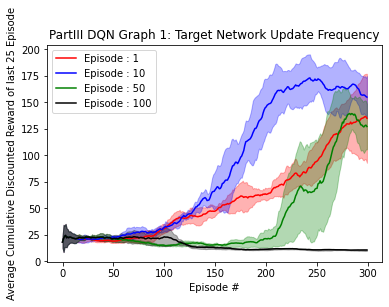

<Figure size 432x288 with 0 Axes>

In [8]:
# PART III.1: Target Network Update Frequency

PREV_TARGET_UPDATE_FREQ = TARGET_UPDATE_FREQ
colors = ['red','blue','green','black']
targetUpdateFrequencies = [1,10,50,100]

for i in range(len(targetUpdateFrequencies)):
    TARGET_UPDATE_FREQ = targetUpdateFrequencies[i]  # Target network update frequency

    # Train for different seeds
    curves = []
    for seedVal in SEEDS:
        curves += [train(seedVal)]

    label = "Episode : " +  str(TARGET_UPDATE_FREQ)

    # Plot the curve for the given seeds
    plot_arrays(curves, colors[i], label)


plt.legend(loc='best')
plt.title("PartIII DQN Graph 1: Target Network Update Frequency")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Reward of last 25 Episode")

plt.savefig('Part3_Prob1.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()

TARGET_UPDATE_FREQ = PREV_TARGET_UPDATE_FREQ

---

### Graph 1: Target network update frequency

---

The above graph shows the impact of *target network* update every 1, 10, 50 and 100 episodes. We know that *target network* periodic updates can mitigate divergence of Non-linear Gradianet Q-learning. 

We know that in DQN, the learning process uses two NN - a main network (*update network*) and a *target network*. Every N episodes, the weight from the *update network* is copied to the *target network*. When N=1, the weight from the *update network* is copied to the target network every episode (meaning, target network update follows *update network* every episode). And when N > 1 (say 10), the *target network* weights are updated less frequently than the *update network* weight (For example, target network weight is updated after every 10 episodes with the update network weights). 

From the above graph, we see that convergence improves when update frequency is increased from 1 to 10, but after crossing a certain threshold - increasing update frequency results in degrading convergence performance. **This means that there is an optimal value for the frequency of updating target network and beyond that point the performance starts degrading. **

In value iteration, we froze the current value for all states, and used it as a target to iteratively improve the value of all states based on a known transition function. Until all state values were updated - the target state values were kept fixed. Once all state values were updated, we updated the target with these new values to repeat the process descibed above. However, in reality the transition function is not known. So to approximate the transition function, we use minibatched samples to approximate all states - and fix the target network weights to update the *Update Network* weights for all of these samples in the minibatch. When all the samples have been exhausted from this minibatch - we transfer the *Update Network* weights to *Target Network* weights, and repeat the same process. This way, the target network in DQN is similar to the target state values in value iteration. 

---

Seed=1
Training:


R25(52.76): 100%|██████████| 300/300 [00:13<00:00, 21.82it/s]


Training finished!
Seed=2
Training:


R25(44.84): 100%|██████████| 300/300 [00:13<00:00, 22.03it/s]


Training finished!
Seed=3
Training:


R25(32.28): 100%|██████████| 300/300 [00:13<00:00, 23.01it/s]


Training finished!
Seed=4
Training:


R25(34.2): 100%|██████████| 300/300 [00:13<00:00, 21.73it/s]


Training finished!
Seed=5
Training:


R25(35.36): 100%|██████████| 300/300 [00:12<00:00, 23.31it/s]


Training finished!
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:24<00:00, 12.50it/s]


Training finished!
Seed=2
Training:


R25(156.72): 100%|██████████| 300/300 [00:24<00:00, 12.38it/s]


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:23<00:00, 13.02it/s]


Training finished!
Seed=4
Training:


R25(184.52): 100%|██████████| 300/300 [00:26<00:00, 11.51it/s]


Training finished!
Seed=5
Training:


R25(122.04): 100%|██████████| 300/300 [00:23<00:00, 12.82it/s]


Training finished!
Seed=1
Training:


R25(161.24): 100%|██████████| 300/300 [00:31<00:00,  9.42it/s]


Training finished!
Seed=2
Training:


R25(194.84): 100%|██████████| 300/300 [00:32<00:00,  9.15it/s]


Training finished!
Seed=3
Training:


R25(192.12): 100%|██████████| 300/300 [00:32<00:00,  9.21it/s]


Training finished!
Seed=4
Training:


R25(192.52): 100%|██████████| 300/300 [00:33<00:00,  8.85it/s]


Training finished!
Seed=5
Training:


R25(177.16): 100%|██████████| 300/300 [00:32<00:00,  9.11it/s]


Training finished!
Seed=1
Training:


R25(168.96): 100%|██████████| 300/300 [00:38<00:00,  7.72it/s]


Training finished!
Seed=2
Training:


R25(158.88): 100%|██████████| 300/300 [00:37<00:00,  7.94it/s]


Training finished!
Seed=3
Training:


R25(177.4): 100%|██████████| 300/300 [00:38<00:00,  7.81it/s]


Training finished!
Seed=4
Training:


R25(167.08): 100%|██████████| 300/300 [00:37<00:00,  7.91it/s]


Training finished!
Seed=5
Training:


R25(174.24): 100%|██████████| 300/300 [00:37<00:00,  8.02it/s]


Training finished!


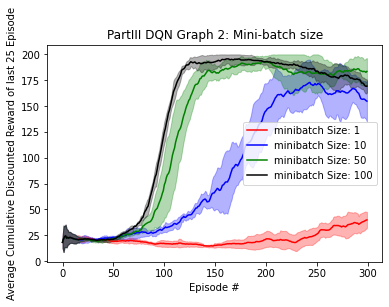

<Figure size 432x288 with 0 Axes>

In [9]:
# PART III.2: Mini-batch size

PREV_MINIBATCH_SIZE = MINIBATCH_SIZE
colors = ['red', 'blue', 'green', 'black']
targetMinibatchSize = [1, 10, 50, 100]

for i in range(len(targetUpdateFrequencies)):
    MINIBATCH_SIZE = targetMinibatchSize[i]  # Target network update frequency

    # Train for different seeds
    curves = []
    for seedVal in SEEDS:
        curves += [train(seedVal)]

    label = "minibatch Size: " + str(MINIBATCH_SIZE)

    # Plot the curve for the given seeds
    plot_arrays(curves, colors[i], label)

plt.legend(loc='best')
plt.title("PartIII DQN Graph 2: Mini-batch size")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Reward of last 25 Episode")

plt.savefig('Part3_Prob2.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()

MINIBATCH_SIZE = PREV_MINIBATCH_SIZE

---

### Graph 2: Mini Batch Size

---

The above graph shows the impact of sampling minibatches of 1, 10 (default), 50 and 100 experience(s) from the replay buffer. Experience replay buffer is used to mitigate divergence of Non-linear Gradianet Q-learning. Gradients are computed with respect to the minibatches. With minibatches, gradients are improved in many locations compared to only one locations. 

When batch size is too small, the model requires more interactions with environment to converge. When the batch size is large, we see that it requires less interaction with environment to converge. 

When minibatch size is 1, it does a online learning - so the learning is more unstable. but as batch size in the replay buffer is increased, more historical state-action state-reward tuples are used - resulting in more stable learning That is why we see that when minibatch size is 1, it does not converge even after 300 episode, but with increasing minibatch size, the reward converges quickly to a reward threshold after less number of episodes. In practice, minibatch size is increased as much as possible to improve the convergence. 

---

Seed=1
Training:


R25(45.36): 100%|██████████| 300/300 [00:05<00:00, 52.74it/s]


Training finished!
Seed=2
Training:


R25(12.72): 100%|██████████| 300/300 [00:05<00:00, 58.89it/s]


Training finished!
Seed=3
Training:


R25(53.24): 100%|██████████| 300/300 [00:06<00:00, 45.26it/s]


Training finished!
Seed=4
Training:


R25(37.56): 100%|██████████| 300/300 [00:06<00:00, 43.49it/s]


Training finished!
Seed=5
Training:


R25(56.8): 100%|██████████| 300/300 [00:06<00:00, 45.93it/s]


Training finished!
Seed=1
Training:


R25(156.72): 100%|██████████| 300/300 [00:23<00:00, 12.71it/s]


Training finished!
Seed=2
Training:


R25(156.72): 100%|██████████| 300/300 [00:23<00:00, 12.82it/s]


Training finished!
Seed=3
Training:


R25(153.84): 100%|██████████| 300/300 [00:22<00:00, 13.45it/s]


Training finished!
Seed=4
Training:


R25(184.52): 100%|██████████| 300/300 [00:25<00:00, 11.79it/s]


Training finished!
Seed=5
Training:


R25(122.04): 100%|██████████| 300/300 [00:22<00:00, 13.08it/s]


Training finished!
Seed=1
Training:


R25(155.52): 100%|██████████| 300/300 [00:38<00:00,  7.79it/s]


Training finished!
Seed=2
Training:


R25(183.4): 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]


Training finished!
Seed=3
Training:


R25(161.88): 100%|██████████| 300/300 [00:39<00:00,  7.63it/s]


Training finished!
Seed=4
Training:


R25(169.84): 100%|██████████| 300/300 [00:39<00:00,  7.64it/s]


Training finished!
Seed=5
Training:


R25(160.04): 100%|██████████| 300/300 [00:36<00:00,  8.20it/s]


Training finished!
Seed=1
Training:


R25(184.76): 100%|██████████| 300/300 [02:08<00:00,  2.33it/s]


Training finished!
Seed=2
Training:


R25(179.64): 100%|██████████| 300/300 [02:06<00:00,  2.36it/s]


Training finished!
Seed=3
Training:


R25(185.36): 100%|██████████| 300/300 [02:08<00:00,  2.33it/s]


Training finished!
Seed=4
Training:


R25(178.68): 100%|██████████| 300/300 [02:08<00:00,  2.33it/s]


Training finished!
Seed=5
Training:


R25(192.16): 100%|██████████| 300/300 [02:10<00:00,  2.29it/s]


Training finished!


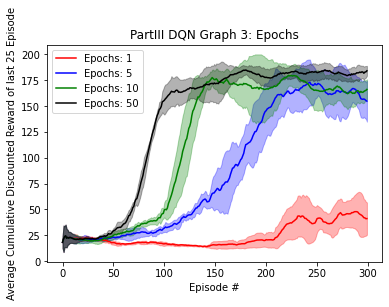

<Figure size 432x288 with 0 Axes>

In [10]:
# PART III.3: Training Epoch

PREV_TRAIN_EPOCHS = TRAIN_EPOCHS
colors = ['red', 'blue', 'green', 'black']
epochs = [1, 5, 10, 50]

for i in range(len(epochs)):
    TRAIN_EPOCHS = epochs[i]  # Target network update frequency

    # Train for different seeds
    curves = []
    for seedVal in SEEDS:
        curves += [train(seedVal)]

    label = "Epochs: " + str(TRAIN_EPOCHS)

    # Plot the curve for the given seeds
    plot_arrays(curves, colors[i], label)

plt.legend(loc='best')
plt.title("PartIII DQN Graph 3: Epochs")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Reward of last 25 Episode")

plt.savefig('Part3_Prob3.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()

TRAIN_EPOCHS = PREV_TRAIN_EPOCHS

---

### Graph 3: Buffer training Epochs

---

The above graph shows the impact of increasing buffer training epochs in sampling minibatches of size 10 from the replay buffer. 

Similar to increasing the minibatch sizes, increasing the number of epochs also improves the results. When only one epoch is used - underfitting of the data occurs. However, we see that as number of epochs are increasing - the convergence is happenning earlier as the Neural network model in DQN is more fitted to the data. 

---